In [ ]:
# Here we take 10000 images from each classes of the CIFAR-10 dataset

import random
import numpy as np
import tensorflow as tf

SEED = 42 

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import seaborn as sns
import pathlib


IMG_SIZE = (224, 224)        # fixed size for both custom and transfer models
BATCH_SIZE = 32
SEED = 42
EPOCHS_CUSTOM = 50
EPOCHS_TL = 20
LEARNING_RATE = 1e-3

In [18]:
# -------------------------
# Data augmentation + preprocessing layers
# -------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.06),
], name="data_augmentation")

# Normalization layer (rescale pixels 0-1)
rescale = layers.Rescaling(1./255)

I0000 00:00:1764528008.732013      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764528008.732639      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [19]:

def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module (CBAM)"""

    channel = input_feature.shape[-1]

    # -------- Channel Attention --------
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    # Shared MLP
    shared_dense_1 = layers.Dense(channel // ratio, activation='relu') # ( 2 layers first contains c/r unit)
    shared_dense_2 = layers.Dense(channel)                             # (second layer contains c unit)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)

    x = layers.Multiply()([input_feature, channel_attention])

    # -------- Spatial Attention --------
    avg_pool_spatial = layers.Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x


def build_custom_cnn_cbam_v2(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)

    #  Data Augmentation + Normalization
    x = data_augmentation(inputs)
    x = rescale(x)

    # ----- Conv Block 1 -----
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 2 -----
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 3 -----
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 4 With CBAM -----
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    # 🔹 Global Pooling (both Avg + Max)
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([gap, gmp])

    # 🔹 Dense Layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='custom_cnn_cbam_v2')
    return model


# -------------------------
# Compile model
# -------------------------
LEARNING_RATE = 1e-3
IMG_SIZE = (224, 224)

CNN_CBAM_model_V2 = build_custom_cnn_cbam_v2(input_shape=IMG_SIZE + (3,))
CNN_CBAM_model_V2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CNN_CBAM_model_V2.summary()

Model: "custom_cnn_cbam_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      8,224 │ global_average_p

 Total params: 538,692 (2.05 MB)

 Trainable params: 537,732 (2.05 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def build_mobileNet_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    # Input + augmentation
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Use MobileNetV2 preprocessing (scales to [-1,1])
    x = layers.Lambda(mobilenet_preprocess)(x)
    
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable
    
    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name='mobilenetv2_tl')
    return model


# Build with base frozen
MobileNetV2_model = build_mobileNet_model(base_trainable=False)
MobileNetV2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
MobileNetV2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def build_efficientnet_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    # EfficientNet preprocessing (also scales to [-1, 1])
    x = layers.Lambda(efficientnet_preprocess)(x)

    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="efficientnet_b0_tl")
    return model



# Build with base frozen
EfficientNetB0_model = build_efficientnet_model(base_trainable=False)
EfficientNetB0_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
EfficientNetB0_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet_b0_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

def build_resnet50_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(resnet_preprocess)(x)

    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable

    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="resnet50_tl")
    return model


# Build with base frozen
ResNet50_model = build_resnet50_model(base_trainable=False)
ResNet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
ResNet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
# Build y_true and y_pred arrays for confusion matrix & classification report
def get_labels_and_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset.unbatch().batch(256):  # manageable chunks
        preds = model.predict(images, verbose=0).ravel()
        y_pred.extend((preds >= 0.5).astype(int).tolist())
        y_true.extend(labels.numpy().astype(int).tolist())
    return np.array(y_true), np.array(y_pred)


# Plot training curves for custom model
def plot_history(history, title_prefix=""):
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['loss'], label='train_loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['accuracy'], label='train_acc')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [33]:

# Custom models (First 3 models)
custom_models_list = [
    ("CNN_CBAM_model_V2", CNN_CBAM_model_V2),
]

# Transfer learning models (Remaining models)
transfer_learning_models_list = [
    ("MobileNetV2_model", MobileNetV2_model),
    ("EfficientNetB0_model", EfficientNetB0_model),
    ("ResNet50_model", ResNet50_model),
]

# Function to handle model training and evaluation
def train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names):
    print(f"\n\n================ Training {model_name} ================\n")

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"{model_name}_best.h5", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ]

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_CUSTOM,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"\n{model_name} Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Get predictions
    y_true, y_pred = get_labels_and_predictions(model, test_ds)

    # Confusion matrix & classification report
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # Plot training history
    plot_history(history, title_prefix=model_name)



In [24]:
print("\n\n==============================")
print("DATASET 2 : NTU DDD2 (drowsy / notdrowsy)")
print("==============================")

data_dir = '/kaggle/input/nthuddd2/train_data'
TARGET_CLASSES = ['drowsy', 'notdrowsy']

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)






DATASET 2 : NTU DDD2 (drowsy / notdrowsy)
Found 66521 files belonging to 2 classes.
Using 46565 files for training.
Found 66521 files belonging to 2 classes.
Using 19956 files for validation.


In [25]:
import os
import random
import shutil
from pathlib import Path

print("\n\n==============================")
print("DATASET 2 : NTU DDD2 (10000 sampled per class)")
print("==============================")

# Original full dataset
data_dir = Path('/kaggle/input/nthuddd2/train_data')

# Temporary sampled dataset folder
sample_dir = Path('/kaggle/working/ntu_sample')
sample_dir.mkdir(exist_ok=True)

# Class names
TARGET_CLASSES = ['drowsy', 'notdrowsy']

# Create class folders inside working directory
for cls in TARGET_CLASSES:
    (sample_dir / cls).mkdir(exist_ok=True)

# Sample 10000 images per class
NUM_SAMPLES = 10000

for cls in TARGET_CLASSES:
    print(f"Sampling for class: {cls}")

    # List all files in this class folder
    cls_files = list((data_dir / cls).glob("*"))

    # Randomly pick 1000 files
    sampled_files = random.sample(cls_files, NUM_SAMPLES)

    # Copy sampled files to working folder
    for file in sampled_files:
        shutil.copy(file, sample_dir / cls)

print("Sampling complete! Using sampled dataset.")




DATASET 2 : NTU DDD2 (10000 sampled per class)
Sampling for class: drowsy
Sampling for class: notdrowsy
Sampling complete! Using sampled dataset.


In [26]:
# Class names
TARGET_CLASSES = ['drowsy', 'notdrowsy']


sample_dir = Path('/kaggle/working/ntu_sample')


# ------------------------------------------------
# Load dataset from sampled folder
# ------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    sample_dir,
    labels="inferred",
    label_mode="binary",
    class_names=TARGET_CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())



val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 6000 files for validation.


### **Show Some Sample images**

/tmp/ipykernel_47/4035756159.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # float→int


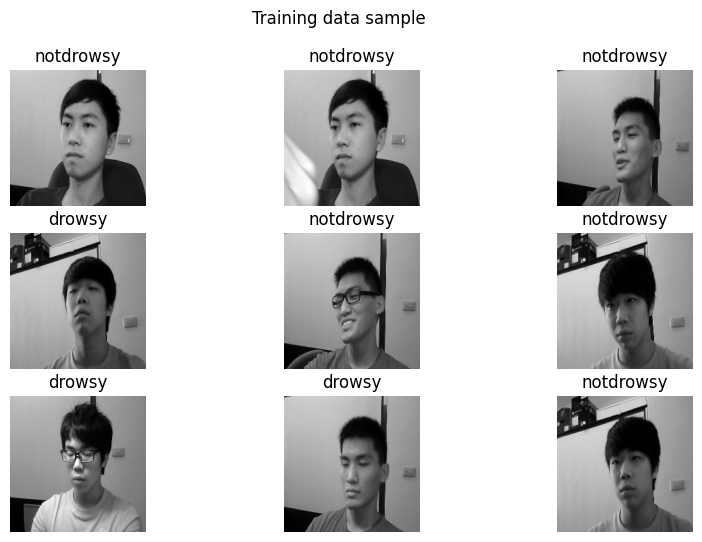

In [27]:

# -------------------------
# Optional: visualize some samples
# -------------------------
def show_batch(dataset, title="Sample images"):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())  # float→int
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training data sample")



================ Training CNN_CBAM_model_V2 ================



94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9428 - loss: 0.1473

CNN_CBAM_model_V2 Test Loss: 0.1435, Test Accuracy: 0.9465

CNN_CBAM_model_V2 - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.96      0.93      0.94      1474
   notdrowsy       0.93      0.96      0.95      1518

    accuracy                           0.95      2992
   macro avg       0.95      0.95      0.95      2992
weighted avg       0.95      0.95      0.95      2992



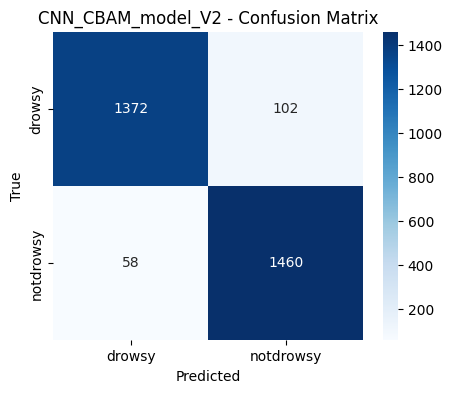

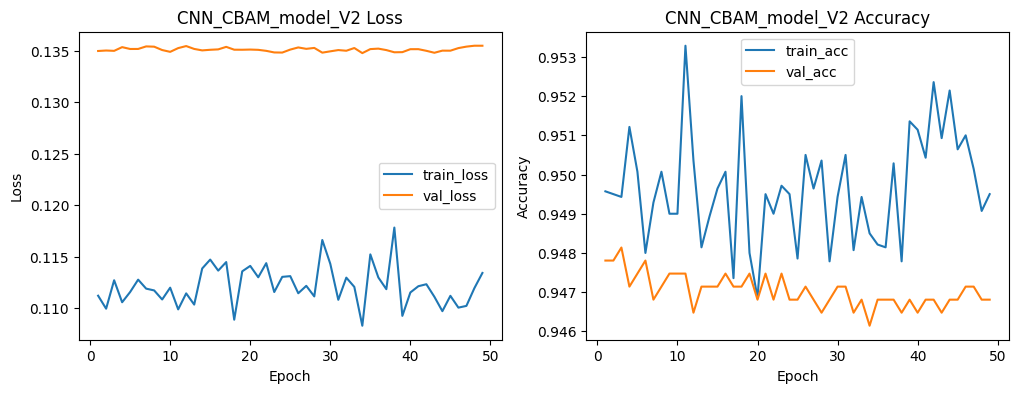

In [34]:
# train on custom model 
for model_name, model in custom_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)



================ Training MobileNetV2_model ================



94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8768 - loss: 0.2859

MobileNetV2_model Test Loss: 0.2801, Test Accuracy: 0.8820

MobileNetV2_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.87      0.90      0.88      1474
   notdrowsy       0.90      0.87      0.88      1518

    accuracy                           0.88      2992
   macro avg       0.88      0.88      0.88      2992
weighted avg       0.88      0.88      0.88      2992



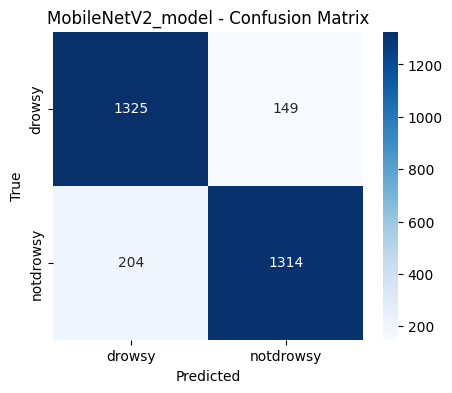

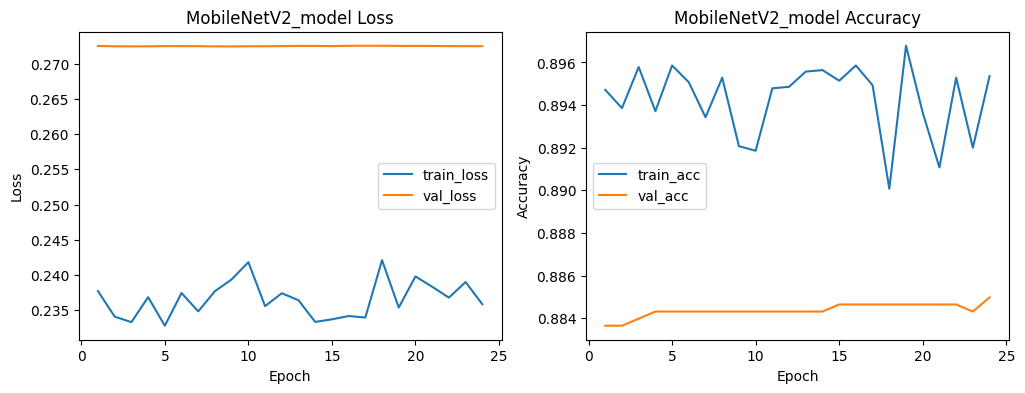



================ Training EfficientNetB0_model ================



94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8459 - loss: 0.3248

EfficientNetB0_model Test Loss: 0.3154, Test Accuracy: 0.8543

EfficientNetB0_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.79      0.96      0.87      1474
   notdrowsy       0.95      0.75      0.84      1518

    accuracy                           0.85      2992
   macro avg       0.87      0.86      0.85      2992
weighted avg       0.87      0.85      0.85      2992



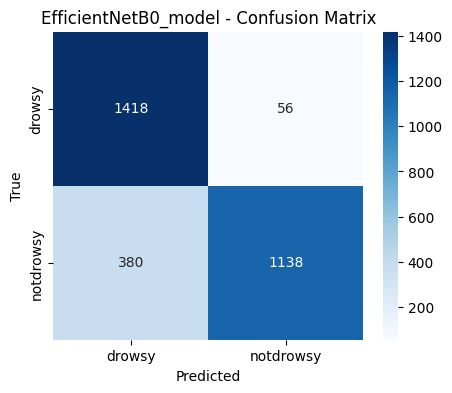

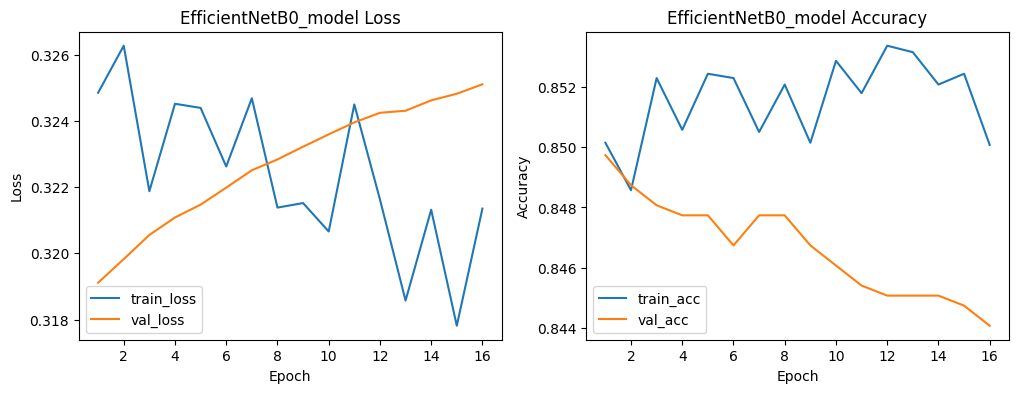



================ Training ResNet50_model ================



94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8441 - loss: 0.3044

ResNet50_model Test Loss: 0.2929, Test Accuracy: 0.8549

ResNet50_model - Classification Report:

              precision    recall  f1-score   support

      drowsy       0.83      0.89      0.86      1474
   notdrowsy       0.88      0.82      0.85      1518

    accuracy                           0.85      2992
   macro avg       0.86      0.86      0.85      2992
weighted avg       0.86      0.85      0.85      2992



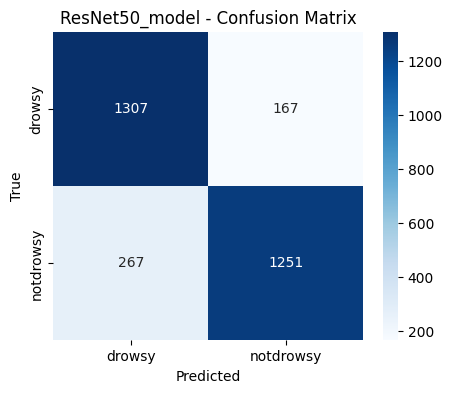

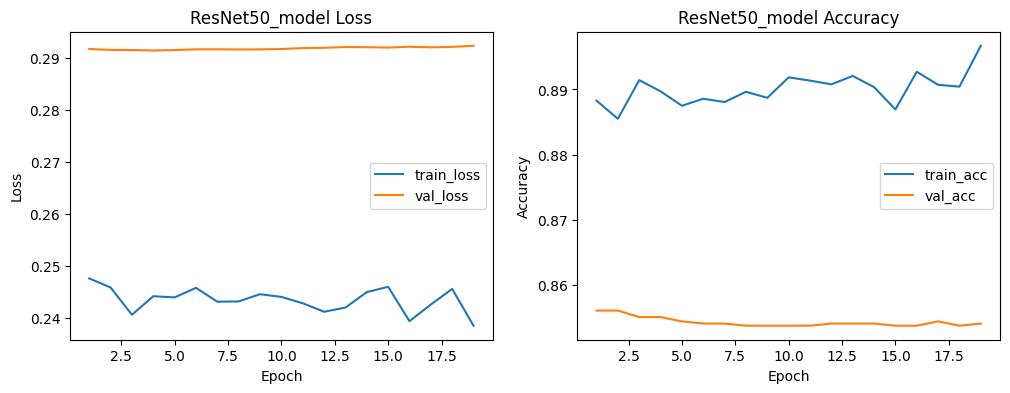

In [37]:

# Training and evaluation for transfer learning models
for model_name, model in transfer_learning_models_list:
    train_and_evaluate_model(model_name, model, train_ds, val_ds, test_ds, EPOCHS_CUSTOM, class_names)
